In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
import itertools
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.nn.utils.prune as prune
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import logging
from functools import partial
from collections import OrderedDict
import seaborn as sns
import matplotlib as mp
import time
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import importlib
import sys

sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models.VQ_VAE import Model
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

import json
from tqdm import tqdm


# Now I'm plugging my own dataset 

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  5 ...
0.0
4194.0


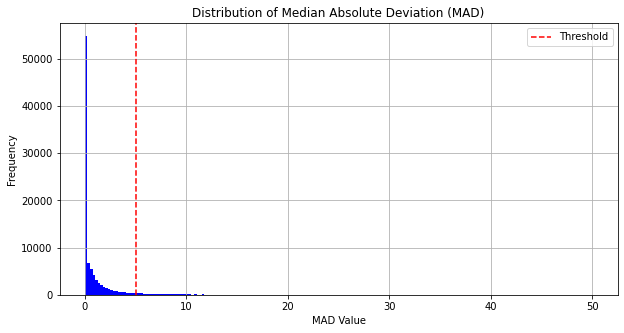

removing 89395 genes under the MAD threshold from the dataset
number of genes selected :  5914
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [5]:
as_time_series = True
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 5, 
    subsample=None, 
    retain_phases = None,
    normalization = False,
    minimum_time_point = "BL",
    as_time_series = False,
    transpose = False,
    MT_removal = False,
    log1p = True,
    min_max = True)

data = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)


In [30]:
# adding my own labels :

metadata_path = "../../METADATA_200123.xlsx"

meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )
patient_ids = [name.split(".")[1] for name in filenames]
clinical_info = meta_data.loc[meta_data['Patient Number'].astype(str).isin(patient_ids), 'Disease Status'].tolist()
clinical_info[0:5]


['Prodromal', 'Prodromal', 'Prodromal', 'Prodromal', 'Prodromal']

back to the regular notebook

In [31]:
dat = pd.DataFrame(data)
feature_num = dat.shape[1]
data_num = dat.shape[0]
dat = dat.values.reshape(-1,1,feature_num)
print(dat.shape)

(4445, 1, 5914)


In [32]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1 ,transform = None):
        self.transform = transform
        self.data1 = data1
        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float() 
        if self.transform:
            out_data1 = self.transform(out_data1)

        return out_data1

In [33]:
train_data, test_data = train_test_split(dat, test_size = 0.3,random_state = 66)
print('train data:',len(train_data))
print('test data:',len(test_data))
train_data_set = Mydatasets(data1 = train_data)
test_data_set = Mydatasets(data1 = test_data)
train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 32, shuffle=False)

train data: 3111
test data: 1334


In [36]:
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for m1 mac
DEVICE = torch.device("mps")

out_dim = 512   
VQ_VAE = Model(
            dropout = 0.0,
            input_size = feature_num, 
            encoder_dim = out_dim,
            num_embeddings = 64,  
            embedding_dim = 64,   
            commitment_cost = 1
           ).to(DEVICE)

Classifier_loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(VQ_VAE.parameters(), lr=1e-3, amsgrad=False)
data_variance = np.var(dat)

print(DEVICE)

mps


Added feature to monitor training


Epoch 1/20, Training Loss: 39.676060731594376, Validation Loss: 2.321684644335792


Epoch 2/20, Training Loss: 2.1477424915020285, Validation Loss: 2.2997112558001565


Epoch 3/20, Training Loss: 1.165575949045328, Validation Loss: 0.6628027331261408


Epoch 4/20, Training Loss: 0.6358068035199091, Validation Loss: 0.5977823535601298


Epoch 5/20, Training Loss: 0.5702247986426721, Validation Loss: 0.5818708290656408


Epoch 6/20, Training Loss: 0.6001493288920476, Validation Loss: 0.6892455873035249


Epoch 7/20, Training Loss: 0.7084958278215848, Validation Loss: 0.6597418827669961


Epoch 8/20, Training Loss: 0.5973787720386798, Validation Loss: 0.7716021126224881


Epoch 9/20, Training Loss: 0.8678099650603074, Validation Loss: 0.6755291308675494


Epoch 10/20, Training Loss: 0.6571743809259855, Validation Loss: 0.8304926313105083


Epoch 11/20, Training Loss: 0.6882506104616019, Validation Loss: 0.6732062910284314


Epoch 12/20, Training Loss: 0.7186039548653823, Validation Loss: 0.6831688001042321


Epoch 13/20, Training Loss: 0.6469292961634122, Validation Loss: 0.6990737645399003


Epoch 14/20, Training Loss: 0.7408026686081519, Validation Loss: 0.7642890846445447


Epoch 15/20, Training Loss: 0.730918471629803, Validation Loss: 0.7527358077821278


Epoch 16/20, Training Loss: 0.7344997479365423, Validation Loss: 0.7705091805685134


Epoch 17/20, Training Loss: 0.6731605552710019, Validation Loss: 0.7372291627384367


Epoch 18/20, Training Loss: 0.6748289557603689, Validation Loss: 0.6773625789653688


Epoch 19/20, Training Loss: 0.6171418107472934, Validation Loss: 0.6867212447382155





100%|██████████| 20/20 [00:29<00:00,  1.47s/it]

Epoch 20/20, Training Loss: 0.5982831028791574, Validation Loss: 0.6036687684910638


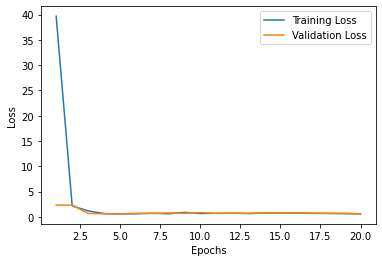

In [38]:
EPOCH = 20
train_res_recon_error = []
val_res_recon_error = []

VQ_VAE.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    quantized_merge = torch.empty(0, 1, 64).to(DEVICE)
    
    # Training loop
    for labels, inputs in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)
        recon_error = F.mse_loss(data_recon, inputs) / data_variance
        loss = recon_error + vq_loss
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
    
    # Calculate and store training loss for this epoch
    train_loss = running_loss / count
    train_res_recon_error.append(train_loss)
    
    # Validation loop (if you have a validation dataset)
    with torch.no_grad():
        running_val_loss = 0.0
        count = 0
        for labels, inputs in enumerate(test_dataloader, 0):
            inputs = inputs.to(DEVICE)
            vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)
            recon_error = F.mse_loss(data_recon, inputs) / data_variance
            loss = recon_error + vq_loss
            count += 1
            running_val_loss += loss.item()
        
        # Calculate and store validation loss for this epoch
        val_loss = running_val_loss / count
        val_res_recon_error.append(val_loss)
    
    # Print and/or plot training and validation loss
    print(f"Epoch {epoch + 1}/{EPOCH}, Training Loss: {train_loss}, Validation Loss: {val_loss}")
    
# Plot training and validation loss curves
epochs = np.arange(1, EPOCH + 1)
plt.plot(epochs, train_res_recon_error, label='Training Loss')
plt.plot(epochs, val_res_recon_error, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
en_lat = []
en_quantized = []
en_reconstruction = []
data_set = Mydatasets(data1 = dat)
#data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=True)
data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=False) 



#vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)


for i in range(len(dat)):
    en_data = data_set.dataset[i][0]
    latent_1 = VQ_VAE._encoder(en_data.view(1, 1, feature_num).float().to(DEVICE))
    _, data_recon, _, _,latent_2 = VQ_VAE(en_data.view(1, 1, feature_num).float().to(DEVICE))
    en_lat.append(latent_1.cpu().detach().numpy())
    en_quantized.append(latent_2.cpu().detach().numpy())
    en_reconstruction.append(data_recon.cpu().detach().numpy())

encode_out = np.array(en_lat)
encode_out = encode_out.reshape(len(dat), -1)
quantized_out = np.array(en_quantized)
quantized_out = quantized_out.reshape(len(dat), -1)
reconstruction_out = np.array(en_quantized)
reconstruction_out = reconstruction_out.reshape(len(dat), -1)

print('encode_out:', encode_out.shape)
print('quantized_out:', quantized_out.shape)

encode_out: (4445, 512)
quantized_out: (4445, 64)


# let's check if the encoding makes sense

In [47]:
latent_Z = encode_out # original approach
#latent_Z = quantized_out # just to see

tsne = TSNE(early_exaggeration=50,
              learning_rate=1000, 
              perplexity=50, 
              min_grad_norm=1e-7, 
              n_iter=5000,
              n_components=2).fit_transform(latent_Z)
x_min, x_max = np.min(tsne, 0), np.max(tsne, 0)
tsne = tsne / (x_max - x_min)
print('TSNE_out:', tsne.shape)

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


TSNE_out: (4445, 2)


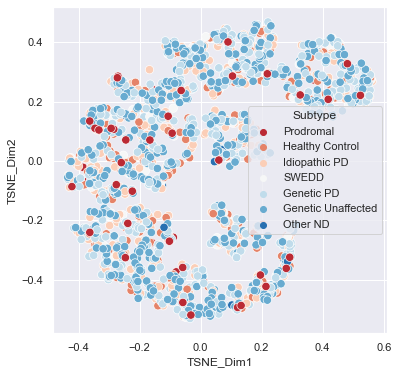

In [48]:

True_labels = pd.DataFrame(clinical_info)



TSNE_result = pd.DataFrame(tsne, columns=['TSNE_Dim1', 'TSNE_Dim2'])
TSNE_result['Subtype'] = True_labels
#tsne of learened feature
plt.figure(figsize=(6,6))
sns.set(style='darkgrid',context='notebook')
sns.scatterplot(data = TSNE_result, x='TSNE_Dim1', y='TSNE_Dim2',hue='Subtype',palette='RdBu',s = 70)

plt.show()

In [49]:
TSNE_result['Subtype']

0       Prodromal
1       Prodromal
2       Prodromal
3       Prodromal
4       Prodromal
          ...    
4440          NaN
4441          NaN
4442          NaN
4443          NaN
4444          NaN
Name: Subtype, Length: 4445, dtype: object

[0.69363004 0.2667352 ]
[6.378685  2.4529212]
pca_result: (4445, 2)


/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_47375/4128091213.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap,c=colors,s=20)
/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


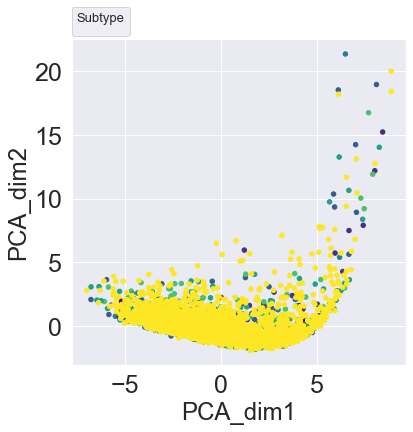

In [50]:
#PCA of learened feature
pca = PCA(n_components=2)
pca.fit(latent_Z)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
pca_result = pca.transform(latent_Z)
print('pca_result:',pca_result.shape)

sns.set(style='darkgrid',context='notebook')
plt.figure(figsize=(6,6)) 

my_cmap = plt.get_cmap('viridis', len(TSNE_result['Subtype'].unique()))
# Map string labels to numeric values
subtype_labels = TSNE_result['Subtype'].unique()
subtype_to_numeric = {subtype: i for i, subtype in enumerate(subtype_labels)}
colors = [my_cmap(subtype_to_numeric[subtype]) for subtype in TSNE_result['Subtype']]

a = plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap,c=colors,s=20)

L = plt.legend(*a.legend_elements(),
           borderaxespad = 1,
           title_fontsize = 13,
           fontsize = 13,
           loc = (0,1.01),
           ncol = 5,
           title="Subtype")

plt.xlabel("PCA_dim1", size=24)  
plt.ylabel("PCA_dim2", size=24)
plt.tick_params(axis='x', which='both', labelsize=25)
plt.tick_params(axis='y', which='both', labelsize=25)

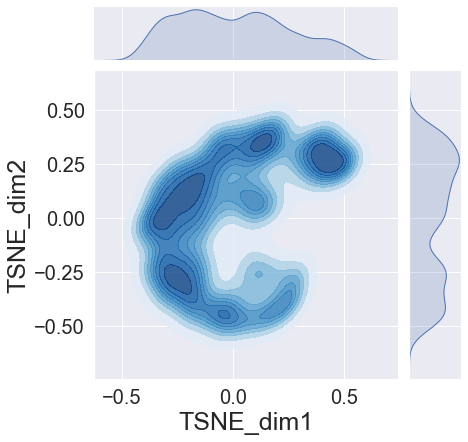

In [51]:
f = sns.jointplot(x=TSNE_result.TSNE_Dim1, y=TSNE_result.TSNE_Dim2, cmap="Blues", fill=True, kind='kde',height=6,
                 marginal_kws={"alpha":.2},thresh=0.05, alpha=.8)
f.ax_joint.set_xlabel("TSNE_dim1",fontsize=25)
f.ax_joint.set_ylabel("TSNE_dim2",fontsize=25)
f.ax_joint.tick_params(labelsize=20)

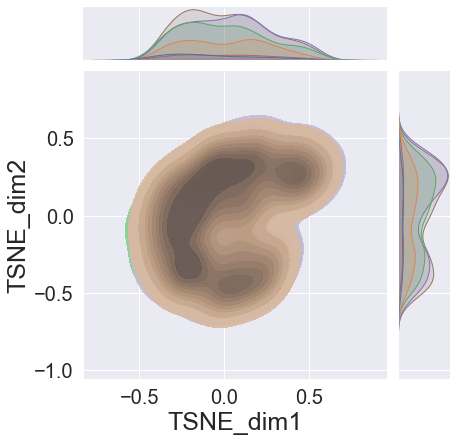

In [52]:
f = sns.jointplot(x=TSNE_result.TSNE_Dim1, y=TSNE_result.TSNE_Dim2, fill=True, kind='kde',hue=TSNE_result.Subtype,height=6,marginal_kws={"alpha":.2},thresh=0.05, alpha=.9)

f.ax_joint.legend_._visible=False
f.ax_joint.set_xlabel("TSNE_dim1",fontsize=25)
f.ax_joint.set_ylabel("TSNE_dim2",fontsize=25)
f.ax_joint.tick_params(labelsize=20)

  0%|          | 0/4445 [08:50<?, ?it/s]


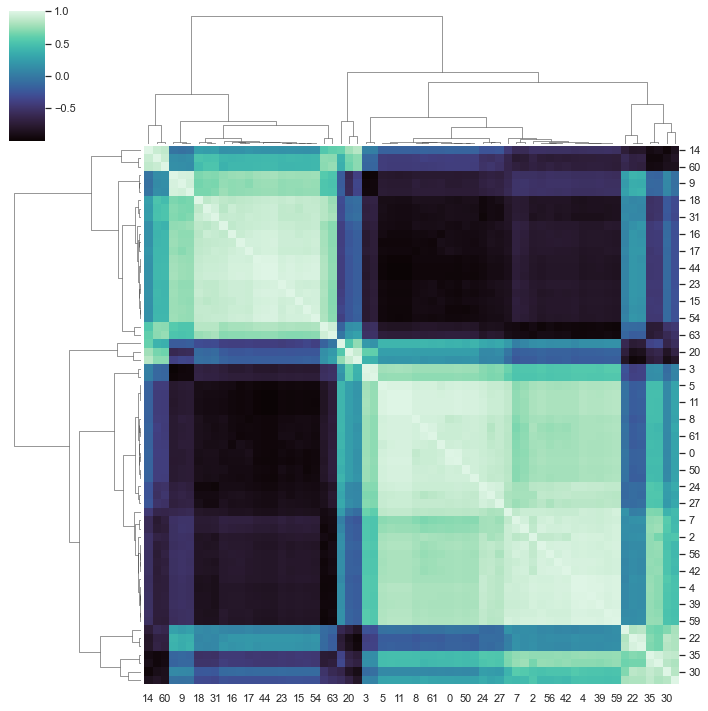

In [53]:
df = pd.DataFrame(quantized_out)
corr = df.corr(method = 'spearman')
sns.clustermap(pd.DataFrame(corr),cmap = 'mako')